In [1]:
import torch
from einops import rearrange,repeat
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import math

In [2]:
class lambda_ffn(nn.Module):
    def __init__(self,input_size,hidden_dim,out_size):
        super().__init__()
        self.input_size=input_size
        self.hidden_dim=hidden_dim
        self.out_size=out_size

        self.layer1=nn.Linear(self.input_size,self.hidden_dim)
        self.layer2=nn.Linear(self.hidden_dim,self.hidden_dim)
        self.layer3=nn.Linear(self.hidden_dim,self.out_size)

        self.gelu=nn.GELU()
        self.lamda=nn.Parameter(torch.normal(mean=0.0,std=1.0,size=(1,1)))
        self.lamda.data.clamp_(-1,1)
        self.x2=0

        self._init_weights()
    
    def _init_weights(self):
        nn.init.kaiming_normal_(self.layer1.weight,
                                mode='fan_out',
                                nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.layer2.weight,
                                mode='fan_out',
                                nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.layer2.weight,
                                mode='fan_out',
                                nonlinearity='leaky_relu')
    def forward(self,x):
        x=self.gelu(self.layer1(x))
        x=self.gelu(self.layer2(x))
        x=self.gelu(self.layer3(x))

        x = self.lamda * x
        self.x2=x
        return x

In [3]:
class MultiHeadedAttention(nn.Module):
    def __init__(self,input_dim,num_heads,qkv_bias=True):
        super().__init__()
        self.input_dim=input_dim
        self.dim=input_dim
        self.num_heads=num_heads
        
        self.qkv_bias=qkv_bias

        self.qkv_scale=self.dim

        self.norm=nn.LayerNorm(self.dim)

        self.qkv=nn.Linear(self.input_dim,self.dim*3,bias=self.qkv_bias)

        
    def forward(self,x):
        
        qkv=self.qkv(x)
        values=rearrange(qkv,'b n (h d k)-> k b h n d',k=3,h=self.num_heads)
        
        q,k,v=tuple(values)

        attn=torch.einsum('b h i d,b h j d -> b h i j',q,k)
        
        attn = attn * (self.qkv_scale**0.5)

        attn = torch.einsum('b h i j, b h j d -> b h i d',attn,v)

        return attn



In [44]:
class Multiple_lamdaffn(nn.Module):
    
    def __init__(self,input_dim,hidden_dimension,n_experts):
        super().__init__()
        self.ffn_experts=nn.ModuleList([])
        self.normlayer=nn.LayerNorm(input_dim)
        self.n_experts=n_experts
        self.w_ffn= nn.Parameter(torch.randn(self.n_experts,1),requires_grad=True)
        for i in range(n_experts):
            self.ffn_experts.append(
                lambda_ffn(input_size=input_dim,hidden_dim=hidden_dimension,out_size=input_dim)
            )
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()  
    def forward(self,x):
        x1=x
        output=0
        for i in range(self.n_experts):
            if i==0:
                output=rearrange(self.ffn_experts[i](x),pattern='b n d -> () b n d')
            else:
                output=torch.cat([output,rearrange(self.ffn_experts[i](x),pattern='b n d -> () b n d')],dim=0)
        output=torch.einsum('e b n d, e o->b n d',output,self.w_ffn)
        return x1 + output

In [45]:
class patch_embedding(nn.Module):
    def __init__(self,patch_size,inchannels,padding,out_dim,stride=None):
        super().__init__()

        print(patch_size,stride,padding)
        self.conv=nn.Conv2d(
                in_channels=inchannels,
                out_channels=out_dim,
                stride=stride,
                kernel_size=patch_size,
                padding=padding
        )
        self.layernorm=nn.LayerNorm(out_dim)
        self.gelu=nn.GELU()
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()
    def forward(self,x):
        x=self.conv(x)
        b,c,h,w= x.shape
        x=self.gelu(x)
        x=rearrange(x,'b c h w -> b (h w) c')
        x=self.layernorm(x)
        return x ,b,c,h,w

In [46]:
class Block(nn.Module):

    def __init__(self,image_size,input_dim,total_stages,num_heads,qkv_bias,mlp_ratio,n_experts,patch_size,padding,stride):
        super().__init__()
        self.input_dim=input_dim
        self.num_heads=num_heads
        self.total_stages=total_stages
        self.qkv_bias=qkv_bias
        self.mlp_ratio=mlp_ratio
        self.n_experts=list(map(int,n_experts))

        self.total_blocks=nn.ModuleList([])
        self.patch_embedding=nn.ModuleList([])

        self.padding=padding
        self.stride=stride
        self.patch_size=patch_size
        for i in range(self.total_stages):
            mlp_hidden=int(self.input_dim[i]*self.mlp_ratio[i])
            if i==0:
                out_dim=self.input_dim[i]
                in_dim=3
                self.height=(image_size-self.patch_size[i]+ 2*self.padding[i])//self.stride[i]
                self.height+=1
            else:
                in_dim=self.input_dim[i-1]
                out_dim=self.input_dim[i]
                self.height = (self.height-self.patch_size[i]+ 2*self.padding[i])//self.stride[i]
                self.height+=1


            
            current_block=nn.ModuleList([
                patch_embedding(patch_size=self.patch_size[i],inchannels=in_dim,out_dim=out_dim,
                                padding=self.padding[i],stride=self.stride[i]),

                MultiHeadedAttention(input_dim=self.input_dim[i],
                                     num_heads=self.num_heads[i],qkv_bias=self.qkv_bias),
                Multiple_lamdaffn(input_dim=int(self.input_dim[i]),
                                  hidden_dimension=mlp_hidden,
                                  n_experts=self.n_experts[i])
            ])
            self.total_blocks.append(
                current_block
            )
    
    def forward(self,x):
        i=0
        for patch,attn,mlp in self.total_blocks:
            print(x.shape)
            x,b,c,h,w=patch(x)
            x_attn=attn(x)
            x_attn=rearrange(x_attn,'b h n c -> b n (c h)')
            x_mlp=mlp(x_attn)
            x=x_mlp
            x=rearrange(x,'b (h w) d -> b d h w',h=h,w=w)
            i+=1
        return x


In [47]:
model=Block(
    input_dim=[16,32,64],
    total_stages=3,
    num_heads=[2,4,8],
    qkv_bias=True,
    mlp_ratio=[2.0,3.0,3.0],
    n_experts=[3.0,5.0,6.0],
    patch_size=[5,3,2],
    stride=[2,2,1],
    padding=[1,0,0],
    image_size=64
)

5 2 1
3 2 0
2 1 0


In [48]:
model(torch.randn(1,3,32,32)).shape

torch.Size([1, 3, 32, 32])
torch.Size([1, 16, 15, 15])
torch.Size([1, 32, 7, 7])


torch.Size([1, 64, 6, 6])

In [49]:
parameters=[i.numel() for i in model.parameters()]

In [50]:
sum(parameters)

486908

In [11]:
model2=nn.Sequential(
    nn.Linear(4096*3,4096),
    nn.Linear(4096,4096),
    nn.Linear(4096,100)
)

In [12]:
param=[i.numel() for i in model2.parameters()]

In [13]:
sum(param)

67526756

In [14]:
nn.Flatten

torch.nn.modules.flatten.Flatten

In [15]:
model3=nn.Sequential(
    nn.Conv2d(3,16,5),
    nn.Conv2d(16,32,3),
    nn.Conv2d(32,32,1),
    nn.Flatten()
)

In [16]:
param=[i.numel() for i in model3.parameters()]
sum(param)

6912

<Axes: >

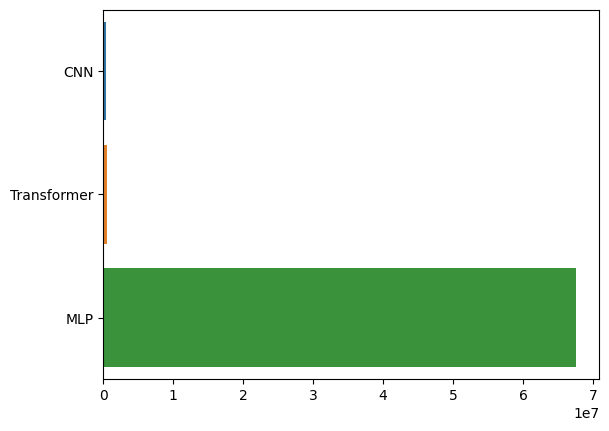

In [17]:
import seaborn as sns

sns.barplot(
    x=[450_000,522014,67526756],
    y=['CNN','Transformer','MLP']
)

In [18]:
522014/67526756

0.007730476494383944